### TT02 -- Building the RAG Model Document Library & Ingestion Pipeline

In [1]:
#we need to import a few libraries
import os
import json
import pypdf

from haystack import Pipeline, PredefinedPipeline
import urllib.request

c:\Users\emtay\Documents\CityU\Winter_2024-25\DIT650\tt_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing Haystack's out-of-the-box functionality

In [2]:
# get text document
file_path = "TT02_Document_Library/emergency_medicine.txt"
urllib.request.urlretrieve("https://archive.org/stream/RosenEM10th/Rosen%27s%20Emergency%20Medicine%20Concepts%20and%20Clinical%20Practice%2C%2010th%20edition%20-%20With%20Bookmarks_djvu.txt",
                           file_path)  

('TT02_Document_Library/emergency_medicine.txt',
 <http.client.HTTPMessage at 0x132298a0c90>)

In [3]:
indexing_pipeline =  Pipeline.from_template(PredefinedPipeline.INDEXING)
indexing_pipeline.run(data={"sources": [file_path]})

rag_pipeline =  Pipeline.from_template(PredefinedPipeline.RAG)

query = "What are the appropriate interventions for this patient? Case: The patient is a 40-year-old white male who presents with a chief complaint of 'chest pain'. \
    The patient is diabetic and has a prior history of coronary artery disease. The patient presents today stating that his chest pain started yesterday evening \
        and has been somewhat intermittent. The severity of the pain has progressively increased. He describes the pain as a sharp and heavy pain which radiates \
            to his neck & left arm. He ranks the pain a 7 on a scale of 1-10. He admits some shortness of breath & diaphoresis. He states that he has had nausea \
                & 3 episodes of vomiting tonight. He denies any fever or chills. He admits prior episodes of similar pain prior to his PTCA in 1995. He states \
                    the pain is somewhat worse with walking and seems to be relieved with rest. There is no change in pain with positioning. He states that he \
                        took 3 nitroglycerin tablets sublingually over the past 1 hour, which he states has partially relieved his pain. The patient ranks his \
                            present pain a 4 on a scale of 1-10. The most recent episode of pain has lasted one-hour."
result = rag_pipeline.run(data={"prompt_builder": {"query":query}, "text_embedder": {"text": query}})
print(result["llm"]["replies"][0])

Calculating embeddings: 375it [04:23,  1.42it/s]


Given the patient's presentation and history, the appropriate interventions include:

1. **Immediate Evaluation:** Due to the patient's history of coronary artery disease and current symptoms, an initial assessment should be conducted quickly. This includes checking vital signs (blood pressure, heart rate, and oxygen saturation) and performing an electrocardiogram (ECG) to assess for signs of acute coronary ischemia.

2. **Oxygen Therapy:** If the patient is exhibiting signs of respiratory distress or has low oxygen saturation, supplemental oxygen should be administered.

3. **Aspirin Administration:** Administering aspirin (if not contraindicated) is essential to inhibit platelet aggregation and mitigate the risk of further clot formation.

4. **Intravenous Access:** Establish IV access for potential medication administration and fluid resuscitation if necessary.

5. **Consider Nitroglycerin:** Although the patient has already taken sublingual nitroglycerin, further nitroglycerin infu

### Save output for later evaluation

In [4]:
def get_next_filename(base_name="TT02_Output", ext=".json"):
    """Find the next available file name"""
    i = 1
    while os.path.exists(f"{base_name}_{i}{ext}"):
        i += 1
    return f"{base_name}_{i}{ext}"

# Generate the next file name
file_name = get_next_filename()

#save as a json
json.dump(result, open(file_name, "w"), default=str, indent=4)

### We may have data in different formats, like PDF documents

In [5]:
# creating a pdf reader object
reader = pypdf.PdfReader('TT02_Document_Library\iitt_adult.pdf')

# let's view the first page (there is only one page for this document)
text = reader.pages[0].extract_text()
print(text[:997])

MOVE TO HIGH ACUITY RESUSCITATION
AREA IMMEDIATELY MOVE TO CLINICAL TREATMENT AREA MOVE TO LOW ACUITY
OR WAITING AREA
Patients with high-risk vital signs 
or clinical concern need 
up-triage or immediate review by 
supervising clinician
INTERAGENCY INTEGRATED TRIAGE TOOL: Age ≥ 12
NO CHECK FOR HIGH-RISK
VITAL SIGNS3
HR <60 or >130 
RR <10 or >30
Temp <36° or >39°
SpO2 <92%
AVPU other than A
NO
YES
*See Reference Card Developed by World Health Organization, The International Committee of the Red Cross, Médecins Sans Frontières
CHECK FOR YELLOW CRITERIA2
AIRWAY & BREATHING
• Any swelling/mass of mouth, throat or neck
• Wheezing (no red criteria)
CIRCULATION
• Vomits everything or ongoing diarrhoea
• Unable to feed or drink
• Severe pallor (no red criteria)
• Ongoing bleeding (no red criteria)
• Recent fainting
OTHER
• New rash worsening over hours or peeling (no red criteria)
• Visible acute limb deformity
• Open fracture
• Suspected dislocation
• Other trauma/burns (no red criteria)



### Build a Haystack pipeline to handle multiple document types

Step 1: Import libraries

In [6]:
#we can import different modules for the functionality we want
import sentence_transformers
from haystack.components.writers import DocumentWriter
from haystack.components.converters import PyPDFToDocument
from haystack.components.converters import TextFileToDocument
from haystack.components.preprocessors import DocumentSplitter, DocumentCleaner
from haystack.components.routers import FileTypeRouter
from haystack.components.joiners import DocumentJoiner
from haystack.components.embedders import SentenceTransformersDocumentEmbedder
from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore

#also had to pip install pypdf (if not already done) and pip install sentence_transformers

Step 2: Create a document store

In [7]:
#create document store
document_store = InMemoryDocumentStore()

Step 3: File conversion

In [8]:
#indicate the types of files to expect
file_type_router = FileTypeRouter(mime_types=["text/plain", "application/pdf"])

#we need converters for the types of documents we are getting
text_file_converter = TextFileToDocument()
pdf_converter = PyPDFToDocument()

#this will join all our documents so they can be fed through the pipeline together
document_joiner = DocumentJoiner()

Step 4: Cleaning and Preprocessing

Refer to: https://docs.haystack.deepset.ai/docs/documentcleaner

In [9]:
#add cleaning and preprocessing functions
document_cleaner = DocumentCleaner() #standardizes and removes extra whitespace
document_splitter = DocumentSplitter(split_by="word", split_length=150, split_overlap=50) #chunks the text with overlap for context, like we did with spaCy

Step 5: Create document embeddings and save to document store

In [10]:
#create document embeddings
document_embedder = SentenceTransformersDocumentEmbedder(model="sentence-transformers/all-MiniLM-L6-v2") #use prebuilt model
document_embedder.warm_up() #download the embedding model

#write the processed documents to the InMemboryDocumentStore
document_writer = DocumentWriter(document_store)

Step 6: Add components to pipeline

In [11]:
preprocessing_pipeline = Pipeline()
preprocessing_pipeline.add_component(instance=file_type_router, name="file_type_router")
preprocessing_pipeline.add_component(instance=text_file_converter, name="text_file_converter")
preprocessing_pipeline.add_component(instance=pdf_converter, name="pypdf_converter")
preprocessing_pipeline.add_component(instance=document_joiner, name="document_joiner")
preprocessing_pipeline.add_component(instance=document_cleaner, name="document_cleaner")
preprocessing_pipeline.add_component(instance=document_splitter, name="document_splitter")
preprocessing_pipeline.add_component(instance=document_embedder, name="document_embedder")
preprocessing_pipeline.add_component(instance=document_writer, name="document_writer")

Step 7: Connect the pipeline components

In [12]:
preprocessing_pipeline.connect("file_type_router.text/plain", "text_file_converter.sources")
preprocessing_pipeline.connect("file_type_router.application/pdf", "pypdf_converter.sources")
preprocessing_pipeline.connect("text_file_converter", "document_joiner")
preprocessing_pipeline.connect("pypdf_converter", "document_joiner")
preprocessing_pipeline.connect("document_joiner", "document_cleaner")
preprocessing_pipeline.connect("document_cleaner", "document_splitter")
preprocessing_pipeline.connect("document_splitter", "document_embedder")
preprocessing_pipeline.connect("document_embedder", "document_writer")


🚅 Components
  - file_type_router: FileTypeRouter
  - text_file_converter: TextFileToDocument
  - pypdf_converter: PyPDFToDocument
  - document_joiner: DocumentJoiner
  - document_cleaner: DocumentCleaner
  - document_splitter: DocumentSplitter
  - document_embedder: SentenceTransformersDocumentEmbedder
  - document_writer: DocumentWriter
🛤️ Connections
  - file_type_router.text/plain -> text_file_converter.sources (List[Union[str, Path, ByteStream]])
  - file_type_router.application/pdf -> pypdf_converter.sources (List[Union[str, Path, ByteStream]])
  - text_file_converter.documents -> document_joiner.documents (List[Document])
  - pypdf_converter.documents -> document_joiner.documents (List[Document])
  - document_joiner.documents -> document_cleaner.documents (List[Document])
  - document_cleaner.documents -> document_splitter.documents (List[Document])
  - document_splitter.documents -> document_embedder.documents (List[Document])
  - document_embedder.documents -> document_writer.

Step 8: Test the pipeline

In [13]:
from pathlib import Path

# get all our documents
folder_path = "./TT02_Document_Library/"
files = list(Path(folder_path).rglob("*"))

# run the pipeline
preprocessing_pipeline.run({"file_type_router": {"sources": files}})

Batches: 100%|██████████| 750/750 [14:16<00:00,  1.14s/it]


{'document_writer': {'documents_written': 23971}}

In [14]:
#checking it got all the files
print("Files to process:", files)

Files to process: [WindowsPath('TT02_Document_Library/emergency_medicine.txt'), WindowsPath('TT02_Document_Library/iitt_adult.pdf'), WindowsPath('TT02_Document_Library/iitt_pediatric.pdf'), WindowsPath('TT02_Document_Library/iitt_reference-card09165e1c-0df5-472d-ab53-45506191a7bd.pdf')]


### Visualize Pipeline

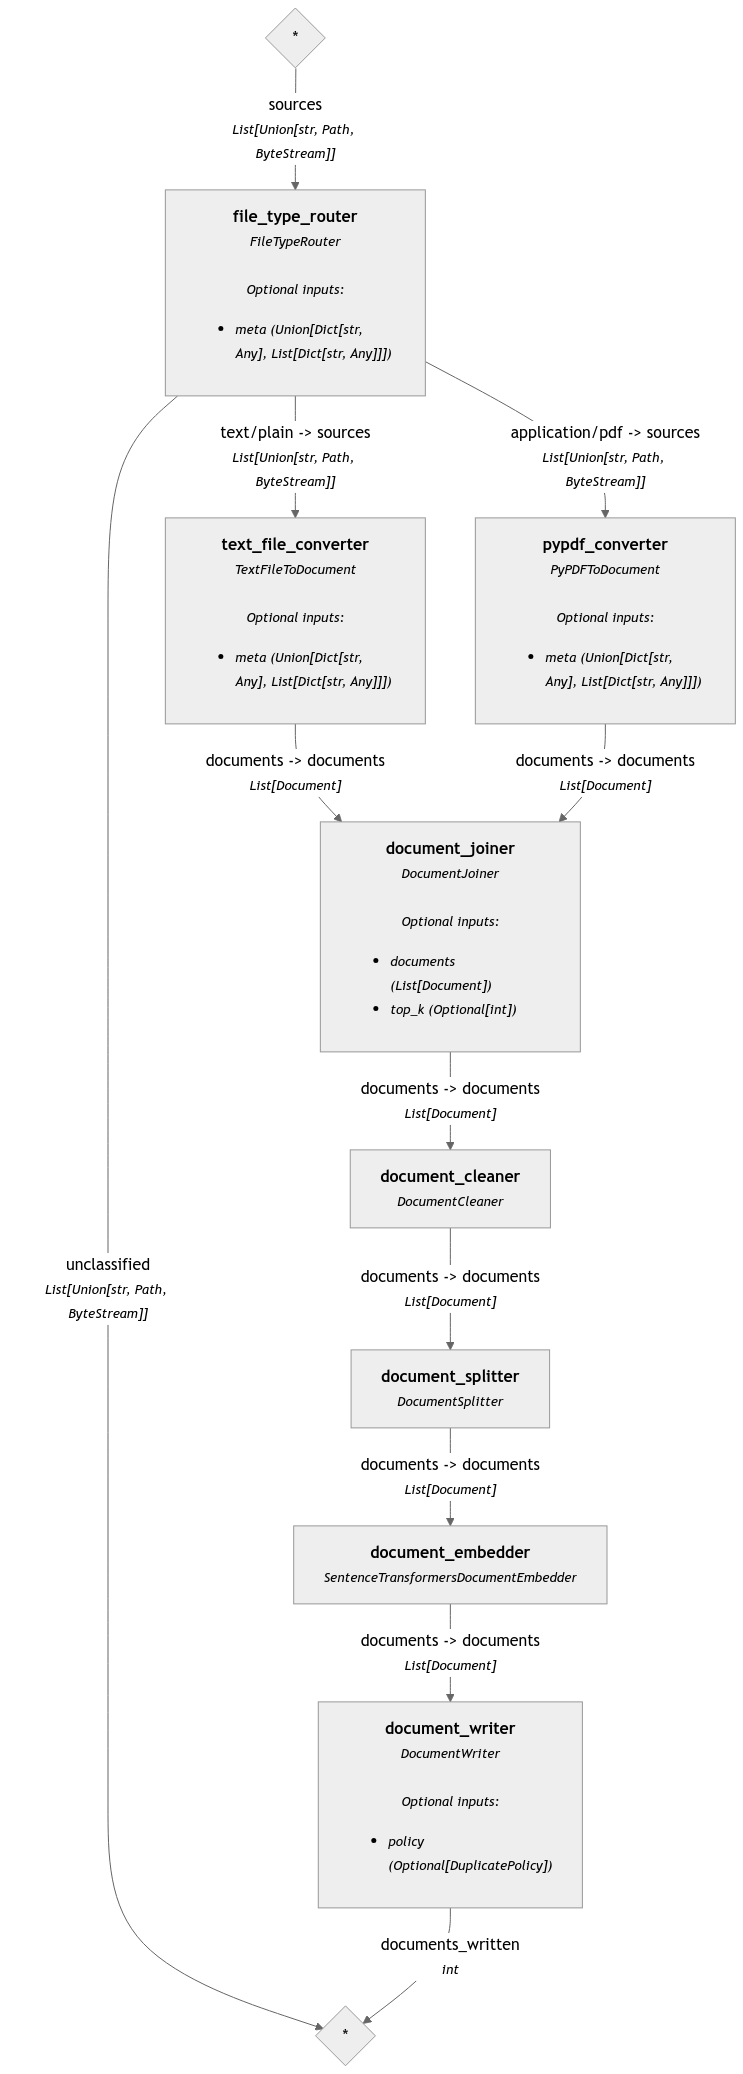

In [15]:
preprocessing_pipeline.show()

### Save Pipeline

In [16]:
with open("preprocessing_pipeline.yml", "w") as file:
  preprocessing_pipeline.dump(file)